In [13]:
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

In [14]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [21]:
SOS_token = 0
EOS_token = 1

#initialize Lang Class
class Lang:
   def __init__(self, name):
       #initialize containers to hold the words and corresponding index
       self.name = name
       self.word2index = {}
       self.word2count = {}
       self.index2word = {0: "SOS", 1: "EOS"}
       self.n_words = 2  # Count SOS and EOS

#split a sentence into words and add it to the container
   def addSentence(self, sentence):
       for word in sentence.split(' '):
           self.addWord(word)

#If the word is not in the container, the word will be added to it, 
#else, update the word counter
   def addWord(self, word):
       if word not in self.word2index:
           self.word2index[word] = self.n_words
           self.word2count[word] = 1
           self.index2word[self.n_words] = word
           self.n_words += 1
       else:
           self.word2count[word] += 1

In [22]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    return s

In [105]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the original language file
    with open('/kaggle/input/urdu-eng-dev/urd_Arab.dev', encoding='utf-8') as f1:
        lang1_lines = f1.read().strip().split('\n')

    # Read the translated language file
    with open('/kaggle/input/urdu-eng-dev/eng_Latn.dev', encoding='utf-8') as f2:
        lang2_lines = f2.read().strip().split('\n')

    # Ensure both files have the same number of lines
    if len(lang1_lines) != len(lang2_lines):
        raise ValueError("The two files have different numbers of lines!")

    # Form pairs and normalize
    pairs = [[normalizeString(lang1), normalizeString(lang2)] for lang1, lang2 in zip(lang1_lines, lang2_lines)]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)


    return input_lang, output_lang, pairs

In [167]:
MAX_LENGTH = 30

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH
       
def filterPairs(pairs):
    return [pair for pair in pairs]

In [168]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('urdu', 'eng', False)
print(random.choice(pairs))

Reading lines...
Read 997 sentence pairs
Trimmed to 997 sentence pairs
Counting words...
Counted words:
urdu 6260
eng 6183
['اس فرد کا نام حکام کے ليے اب بھی نا معلوم ہے اگرچہ ان کو معلوم ہے کہ اس کا تعلق اويیغور نسلی گروہ سے ہے۔', 'his name is still unknown to authorities, although they do know he is a member of the uighur ethnic group .']


In [169]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [170]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [171]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [172]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [186]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    input_length = min(input_tensor.size(0), max_length)

    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [187]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [188]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [189]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [199]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = min(input_tensor.size()[0], MAX_LENGTH)
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [214]:
def evaluateRandomly(encoder, decoder, n=10):
    ground_truth = []
    predicted = []
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        ground_truth.append(pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        predicted.append(output_sentence)
    return ground_truth, predicted
        

In [203]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=500)

evaluateRandomly(encoder1, attn_decoder1)

0m 35s (- 87m 23s) (500 0%) 5.5833
1m 4s (- 79m 59s) (1000 1%) 5.7903
1m 34s (- 76m 55s) (1500 2%) 5.6226
2m 3s (- 75m 20s) (2000 2%) 5.6853
2m 33s (- 74m 21s) (2500 3%) 5.7096
3m 3s (- 73m 32s) (3000 4%) 5.5931
3m 34s (- 72m 55s) (3500 4%) 5.4590
4m 4s (- 72m 26s) (4000 5%) 5.5315
4m 35s (- 72m 3s) (4500 6%) 5.4319
5m 6s (- 71m 33s) (5000 6%) 5.3634
5m 37s (- 71m 7s) (5500 7%) 5.2194
6m 8s (- 70m 37s) (6000 8%) 5.0593
6m 39s (- 70m 7s) (6500 8%) 4.9170
7m 9s (- 69m 35s) (7000 9%) 4.7494
7m 40s (- 69m 7s) (7500 10%) 4.6569
8m 12s (- 68m 41s) (8000 10%) 4.5857
8m 42s (- 68m 9s) (8500 11%) 4.4673
9m 13s (- 67m 39s) (9000 12%) 4.2510
9m 44s (- 67m 7s) (9500 12%) 4.0986
10m 14s (- 66m 34s) (10000 13%) 4.0451
10m 45s (- 66m 3s) (10500 14%) 3.8407
11m 15s (- 65m 31s) (11000 14%) 3.7968
11m 47s (- 65m 4s) (11500 15%) 3.7257
12m 17s (- 64m 33s) (12000 16%) 3.5551
12m 48s (- 64m 2s) (12500 16%) 3.5296
13m 19s (- 63m 34s) (13000 17%) 3.3752
13m 51s (- 63m 6s) (13500 18%) 3.1964
14m 22s (- 62m 39

In [204]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.2).to(device)

trainIters(encoder1, attn_decoder1, 20000, print_every=500)

evaluateRandomly(encoder1, attn_decoder1)

0m 29s (- 19m 0s) (500 2%) 5.3890
0m 58s (- 18m 31s) (1000 5%) 5.6733
1m 27s (- 17m 57s) (1500 7%) 5.6329
1m 57s (- 17m 34s) (2000 10%) 5.6538
2m 26s (- 17m 8s) (2500 12%) 5.6977
2m 57s (- 16m 46s) (3000 15%) 5.6825
3m 27s (- 16m 16s) (3500 17%) 5.4888
3m 58s (- 15m 52s) (4000 20%) 5.5125
4m 28s (- 15m 24s) (4500 22%) 5.3339
4m 58s (- 14m 56s) (5000 25%) 5.2555
5m 29s (- 14m 28s) (5500 27%) 5.2250
6m 0s (- 14m 0s) (6000 30%) 5.0914
6m 30s (- 13m 31s) (6500 32%) 4.9427
7m 1s (- 13m 2s) (7000 35%) 4.8243
7m 32s (- 12m 33s) (7500 37%) 4.7862
8m 3s (- 12m 4s) (8000 40%) 4.5094
8m 33s (- 11m 35s) (8500 42%) 4.4727
9m 4s (- 11m 5s) (9000 45%) 4.4272
9m 36s (- 10m 36s) (9500 47%) 4.1339
10m 7s (- 10m 7s) (10000 50%) 4.1241
10m 38s (- 9m 37s) (10500 52%) 3.9764
11m 10s (- 9m 8s) (11000 55%) 3.9168
11m 41s (- 8m 38s) (11500 57%) 3.7770
12m 11s (- 8m 7s) (12000 60%) 3.6718
12m 42s (- 7m 37s) (12500 62%) 3.4756
13m 13s (- 7m 7s) (13000 65%) 3.4555
13m 45s (- 6m 37s) (13500 67%) 3.3780
14m 16s (- 

In [205]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
import matplotlib.pyplot as plt

In [215]:
ground_truth, predicted = evaluateRandomly(encoder1, attn_decoder1, 20)

> یہ شرايط اس ليے وضع کی گيی ہیں تاکہ دونوں ملکوں کے مابین مہاجرین کی امد و رفت کو منظم کیا جا سکے۔
= these requirements are designed to provide an organized migratory flow between both countries .
< these requirements involves distances provide a mile migratory flow of both countries countries countries to be countries countries . <EOS>

> کچھ جرمن راحب وہاں کے مقامی لوگوں کو خدا کے قریب لانا چاہتے تھے، اسليے انہوں نے ایسٹونیا کی لغوی زبان ایجاد کی-
= some german monks wanted to bring god closer to the native people, so they invented the estonian literal language .
< some german monks wanted to bring god closer from german and and a of they invented of the day . <EOS>

> انعام کے وقت، اٹلانٹا کے اسکولوں میں ٹیسٹ اسکورز میں بہتری نظر ايی تھی۔
= at the time of the award, atlanta schools had seen a large improvement on test scores .
< at the the time the award, atlanta schools had seen had seen a improvement improvement . <EOS>

> سورج میں زمین کی طرح پرت نہیں ہے کہ اپ اسکے اوپر کھڑے ہو 

In [212]:
%matplotlib inline

Pair 1: BLEU Score = 0.5548
Pair 2: BLEU Score = 0.3763
Pair 3: BLEU Score = 0.3985
Pair 4: BLEU Score = 0.1750
Pair 5: BLEU Score = 0.5455
Pair 6: BLEU Score = 0.2140
Pair 7: BLEU Score = 0.4978
Pair 8: BLEU Score = 0.1817
Pair 9: BLEU Score = 0.2845
Pair 10: BLEU Score = 0.1371


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


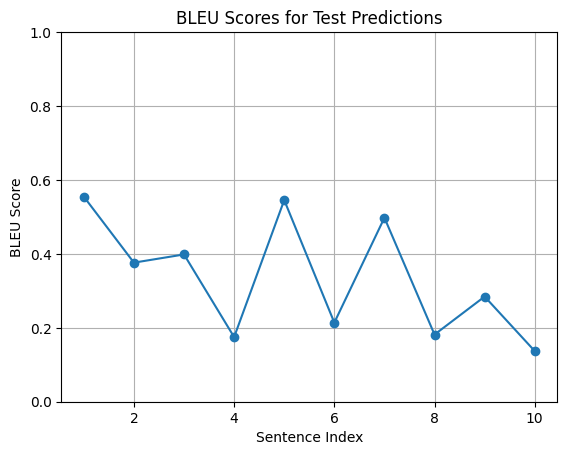

In [216]:
ground_truth_split = [test.split() for test in ground_truth]
predicted_split = [pred.split() for pred in predicted]

# Calculate BLEU scores for each pair
bleu_scores = [
    sentence_bleu([gt], pred)  # Pass ground truth as a list of references
    for gt, pred in zip(ground_truth_split, predicted_split)
]

# Print BLEU scores for each pair
for i, score in enumerate(bleu_scores):
    print(f"Pair {i + 1}: BLEU Score = {score:.4f}")

# Plot BLEU scores
plt.plot(range(1, len(bleu_scores) + 1), bleu_scores, marker='o')
plt.title("BLEU Scores for Test Predictions")
plt.xlabel("Sentence Index")
plt.ylabel("BLEU Score")
plt.ylim(0, 1)  # BLEU scores range from 0 to 1
plt.grid()
plt.show()

In [217]:
ground_truth, predicted = evaluateRandomly(encoder1, attn_decoder1, 20)

> چند سکوں کے عوض بعض بچے تم کو یہ اسٹوری سنا دیں گے۔
= for a few pennies some children will tell you the story .
< in a few pennies some in the be <EOS>

> اس نے مقامی یونیورسٹی کے طلبہ کو ای میل کی اور مفت رہايش کے لیے بے تحاشا تعداد میں پیشکشوں کو موصول کیا۔
= he emailed students at the local university and received an overwhelming number of offers for free accommodation .
< he emailed students an of an local of and services services out of for overwhelming number of number year . <EOS>

> جانور پوری زمین پر پايے جاتے ہیں- وہ زمین کو کھودتے ہیں، سمندروں میں تیرتے ہیں اور اسمان میں اڑتے ہیں-
= animals are found all over the earth . they dig in the ground, swim in the oceans, and fly in the sky .
< the are found in the earth . they most in most animals are in and most and and and . <EOS>

> غیرمطلوب مجسمے یا لکھايیوں کو گریفٹی کے طور پر جانا جاتا ہے۔
= unwanted murals or scribble is known as graffiti .
< another famous greek often a mathematician is a the the be the . <EOS>

> تنا کھا

Pair 1: BLEU Score = 0.2261
Pair 2: BLEU Score = 0.3241
Pair 3: BLEU Score = 0.1650
Pair 4: BLEU Score = 0.6148
Pair 5: BLEU Score = 0.6053
Pair 6: BLEU Score = 0.3506
Pair 7: BLEU Score = 0.2985
Pair 8: BLEU Score = 0.1195
Pair 9: BLEU Score = 0.3639
Pair 10: BLEU Score = 0.3131
Pair 11: BLEU Score = 0.5886
Pair 12: BLEU Score = 0.2047
Pair 13: BLEU Score = 0.5388
Pair 14: BLEU Score = 0.1833
Pair 15: BLEU Score = 0.5133
Pair 16: BLEU Score = 0.2572
Pair 17: BLEU Score = 0.2831
Pair 18: BLEU Score = 0.4954
Pair 19: BLEU Score = 0.8932
Pair 20: BLEU Score = 0.7612


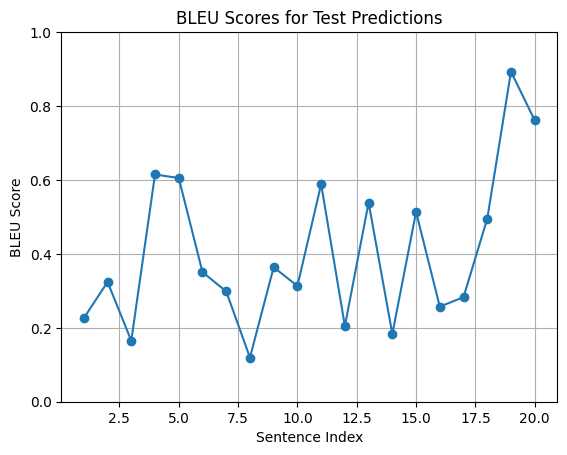

In [218]:
ground_truth_split = [test.split() for test in ground_truth]
predicted_split = [pred.split() for pred in predicted]

# Calculate BLEU scores for each pair
bleu_scores = [
    sentence_bleu([gt], pred)  # Pass ground truth as a list of references
    for gt, pred in zip(ground_truth_split, predicted_split)
]

# Print BLEU scores for each pair
for i, score in enumerate(bleu_scores):
    print(f"Pair {i + 1}: BLEU Score = {score:.4f}")

# Plot BLEU scores
plt.plot(range(1, len(bleu_scores) + 1), bleu_scores, marker='o')
plt.title("BLEU Scores for Test Predictions")
plt.xlabel("Sentence Index")
plt.ylabel("BLEU Score")
plt.ylim(0, 1)  # BLEU scores range from 0 to 1
plt.grid()
plt.show()

In [219]:
torch.save(encoder1.state_dict(), 'encoder_weights.pth')
torch.save(attn_decoder1.state_dict(), 'decoder_weights.pth')

In [221]:
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.2).to(device)


encoder2.load_state_dict(torch.load('/kaggle/working/encoder_weights.pth'))
attn_decoder2.load_state_dict(torch.load('/kaggle/working/decoder_weights.pth'))

/tmp/ipykernel_23/3832047486.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder2.load_state_dict(torch.load('/kaggle/working/encoder_weights.pth'))
/tmp/ipykernel_2

<All keys matched successfully>

In [222]:


evaluateRandomly(encoder2, attn_decoder2, 5)

> انسان ہزاروں برسوں سے بڑی بینايی کے ليے چشمے بناتے رہے ہيں اور اسے استعمال کرتے رہے ہیں۔
= humans have been making and using lenses for magnification for thousands and thousands of years .
< humans have been making and using lenses for thousands and for thousands and for thousands . <EOS>

> اگر مسافر سراب کا پیچھا کرے تو یہ خطرناک ہوسکتے ہیں ، جس میں قیمتی وقت اور بقیہ پانی ضايع ہو۔
= these can be dangerous if the traveler pursue the mirage, wasting precious energy and remaining water .
< these can be dangerous by the car of the energy they of the by the . the by <EOS>

> اٹلانٹا تھریشرز پر واشنگٹن کی 5-3 سے جیت میں انہوں نے 2 گولز داغے اور 2 گول کرنے میں مدد کی۔
= he had 2 goals and 2 assists in washington's 5-3 win over the atlanta thrashers .
< he had 2 goals in the and city of the and that the and passions and passions the dissemination of the <EOS>

> لو کی کشش مجھے کیسے کھینچ سکتی ہے؟ اگر تم لو کی سطح پر کھڑے ہو تو تمہارا وزن زمین پر تمہارے وزن سے کم ہو گا۔
= how would io's gr

(['humans have been making and using lenses for magnification for thousands and thousands of years .',
  'these can be dangerous if the traveler pursue the mirage, wasting precious energy and remaining water .',
  "he had 2 goals and 2 assists in washington's 5-3 win over the atlanta thrashers .",
  "how would io's gravity pull on me ? if you stood on the surface of io, you would weigh less than you do on earth .",
  'arias tested positive for a mild case of the virus, presidential minister rodrigo arias said .'],
 ['humans have been making and using lenses for thousands and for thousands and for thousands . <EOS>',
  'these can be dangerous by the car of the energy they of the by the . the by <EOS>',
  'he had 2 goals in the and city of the and that the and passions and passions the dissemination of the <EOS>',
  "how would io's gravity pull on me on me on if you stood they will stood of the less . <EOS>",
  'a global suspected the fewest of the islands, of the club, . <EOS>'])